In [2]:
import pandas as pd
import numpy as np
import sklearn
from xgboost import XGBClassifier
import xgboost
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import pickle
from sklearn.utils import shuffle

In [3]:
#Don't use datetime, Don't use categorical features, xgboost doesn't those, first one hot encode
featuresToUse = ['prop_id', 'srch_id', 'visitor_hist_starrating', 'visitor_hist_adr_usd',
       'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score',
       'orig_destination_distance', 'comp1_rate', 'comp1_inv']
labelToPredict = 'click_bool'
neededVars = ['booking_bool']
nameOfModel = "testJanine.model"

In [4]:
df = pd.read_csv('C:/Users/janine van wonderen/Desktop/dmt2/80PercentTrainWithMean.csv', delimiter=",",usecols=featuresToUse+[labelToPredict]+neededVars)
dfNeeded= df[neededVars+[labelToPredict]]
Y = df[labelToPredict]
df.drop(neededVars+[labelToPredict],axis=1,inplace=True)

In [5]:
df['Bookings_srch_des_prop_id'] = df.groupby(['srch_destination_id','prop_id'])["booking_bool"].transform(su)
df = df.sort_values(['prop_id','srch_destination_id'])
df = df[['prop_id', 'srch_destination_id', 'booking_bool', "Bookings_srch_des_prop_id"]]
df = df.loc[df["Aantal"]>100]

KeyError: 'Column not found: booking_bool'

In [ ]:
#df2 = df.sort_values('srch_id')
#sizegroups = df2['srch_id'].value_counts().sort_index()


In [13]:
df['Distance'] = df.groupby(['srch_id'])["orig_destination_distance"].transform('mean')

In [15]:
x = df.groupby(['srch_id'])["orig_destination_distance"].mean()

In [14]:
df[["srch_id", "orig_destination_distance", "Distance"]].head()

,srch_id,orig_destination_distance,Distance
0,237770,NaN,NaN
1,129536,NaN,NaN
2,58673,NaN,NaN
3,153134,78.19,73.635833
4,308484,249.86,250.162308


In [12]:
df[["srch_id", "orig_destination_distance", "Distance"]].head()

,srch_id,orig_destination_distance,Distance
0,237770,NaN,NaN
1,129536,NaN,NaN
2,58673,NaN,NaN
3,153134,78.19,NaN
4,308484,249.86,237.682857


Lets train it on clicking

In [6]:
# construct xgboost.DMatrix from numpy array, treat -999.0 as missing value
#xgmat = xgboost.DMatrix( df, label=y_train)
xgmat = xgboost.DMatrix( df, label=Y)
# setup parameters for xgboost
param = {}
# use logistic regression loss, use raw prediction before logistic transformation
# since we only need the rank
param['objective'] = 'reg:logistic'
# scale weight of positive examples
param['scale_pos_weight'] = sum(Y==0)/sum(Y==1)
param['eta'] = 0.01
param['max_depth'] = 6
param['eval_metric'] = 'auc'
param['silent'] = 0

#xgboost.set_group = sizegroups




C:\Users\janine van wonderen\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\janine van wonderen\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [7]:
# you can directly throw param in, though we want to watch multiple metrics here
plst = list(param.items())

watchlist = [ (xgmat,'train') ]
# boost 120 trees
num_round = 120
print ('loading data end, start to boost trees')
bst = xgboost.train( plst, xgmat, num_round, watchlist ,early_stopping_rounds=5);
# save out model
bst.save_model(nameOfModel)

print ('finish training')

loading data end, start to boost trees
[0]	train-auc:0.662682
Will train until train-auc hasn't improved in 5 rounds.
[1]	train-auc:0.662862
[2]	train-auc:0.663651
[3]	train-auc:0.663694
[4]	train-auc:0.663897
[5]	train-auc:0.663902
[6]	train-auc:0.664416
[7]	train-auc:0.665031
[8]	train-auc:0.66605
[9]	train-auc:0.666293
[10]	train-auc:0.666349
[11]	train-auc:0.666384
[12]	train-auc:0.666775
[13]	train-auc:0.666853
[14]	train-auc:0.667102
[15]	train-auc:0.667303
[16]	train-auc:0.667398
[17]	train-auc:0.667499
[18]	train-auc:0.667707
[19]	train-auc:0.667941
[20]	train-auc:0.668147
[21]	train-auc:0.668353
[22]	train-auc:0.668557
[23]	train-auc:0.66871
[24]	train-auc:0.668746
[25]	train-auc:0.668796
[26]	train-auc:0.668938
[27]	train-auc:0.669071
[28]	train-auc:0.669194
[29]	train-auc:0.669308
[30]	train-auc:0.669621
[31]	train-auc:0.669816
[32]	train-auc:0.669912
[33]	train-auc:0.670024
[34]	train-auc:0.670157
[35]	train-auc:0.670371
[36]	train-auc:0.670493
[37]	train-auc:0.670548
[38]	

In [13]:
bst.get_fscore()

{'prop_location_score2': 1560,
 'promotion_flag': 536,
 'prop_location_score1': 1193,
 'price_usd': 1299,
 'prop_starrating': 1042,
 'srch_length_of_stay': 238,
 'srch_adults_count': 100,
 'prop_review_score': 389,
 'orig_destination_distance': 268,
 'prop_log_historical_price': 170,
 'prop_id': 75,
 'srch_destination_id': 114,
 'srch_children_count': 117,
 'srch_room_count': 132,
 'visitor_hist_starrating': 51,
 'srch_booking_window': 51,
 'visitor_hist_adr_usd': 64,
 'srch_id': 34,
 'prop_brand_bool': 40,
 'srch_query_affinity_score': 29,
 'comp1_rate': 5,
 'comp1_inv': 5,
 'srch_saturday_night_bool': 1}

Text(0,0.5,'Feature Importance Score')

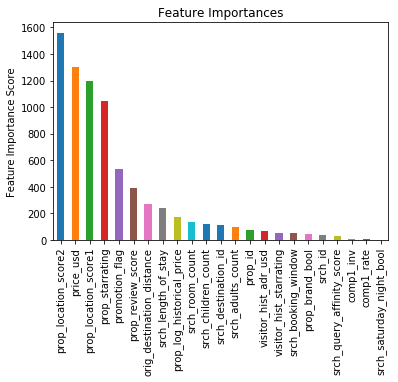

In [15]:
import matplotlib.pylab as plt
feat_imp = pd.Series(bst.get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [ ]:
xgmat_test = xgboost.DMatrix( df, label=Y)
y_pred = bst.predict(xgmat_test)

In [ ]:
predictions = [round(value) for value in y_pred]
df = pd.concat([df,dfNeeded],axis=1)
df['y_pred'] = y_pred

In [ ]:
def getScore(df):
    df['rank_srch_id'] = df.groupby('srch_id').cumcount().add(1)
    df['gain'] = 5*df['booking_bool']
    df['gain'] = np.where(df['gain'] == 0, df['click_bool'], df['gain'])

    df['g/rank'] = df['gain']/df['rank_srch_id']
    gi_sum = df['g/rank'].sum()
    
    df['gain_sorted'] = list(df[['srch_id', 'booking_bool', 'click_bool', 'gain']].sort_values(by = ['srch_id','booking_bool','click_bool'], ascending = [True, False, False])['gain'])
    df['g/rank_sorted'] = df['gain_sorted']/df['rank_srch_id']
    gi_sorted_sum = df['g/rank_sorted'].sum() 
    score = gi_sum/gi_sorted_sum
    return score, gi_sum, gi_sorted_sum

In [ ]:
score, gi_sum, gi_sorted_sum = getScore(df.sort_values(by=['srch_id', 'y_pred'], ascending = [True, False]).reset_index(drop=True))
print(score)

# evaluate predictions
accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
Counter(predictions)

Evaluation

In [10]:
dfTest = pd.read_csv("../data/testWithMean.csv")

In [ ]:
clickingModel = xgboost.Booster({'nthread': 12})  # init model
clickingModel.load_model(nameOfModel)  # load data


In [ ]:
xgmat_test_submission = xgboost.DMatrix(dfTest[featuresToUse])
y_pred_clicking = clickingModel.predict(xgmat_test_submission)
dfTest['predictedPos'] = y_pred_clicking
dfTest = dfTest.sort_values(['srch_id','predictedPos'],ascending=[True, False])
dfSubmission = dfTest[['srch_id','prop_id']]
dfSubmission.to_csv("submissionTest2may.csv",index=False)